## Road Surface Classifier Dataset Preparation

#### About the Dataset

This dataset combines OSM ways w/ labeled surface type (i.e. asphalt, concrete, etc) with corresponding imagery using the [National Agriculture Imagery Program (NAIP) ArcGIS server](https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer). Additionally, binary masks for each of the ways are generated to highlight to our ML model which road in the image we intend to classify.

#### Starting Data
This dataset was derived from all [OpenStreetMap (OSM)](https://www.openstreetmap.org/) ways in the United States that have a labeled [`surface` tag](https://wiki.openstreetmap.org/wiki/Key:surface). The process to obtaining this data is generally as follows:
- Download OSM data for the United States, [here](https://download.geofabrik.de/north-america/us.html)
- Extract all OSM ways with labeled surface type using locally-hosted Overpass API
  - I used [this Docker container by from wiktorn](https://hub.docker.com/r/wiktorn/overpass-api) and [run_overpass_api.sh](/run_overpass_api.sh) to host the OSM Overpass API locally without my downloaded data.
  - The local Overpass API query can be performed using [perform_query.py](/perform_query.py).
  - Use OGR to convert `.osm` (XML) format to `.gpkg` to be easier to work with. In this case we only need the ways (`lines`) layer:
      ```bash
      ogr2ogr us_w_road_surface.gpkg us_w_road_surface.osm lines
      ```
  - This `us_w_road_surface.gpkg` is the starting point for dataset preparation in this notebook.

#### Imports / Configuration

In [2]:
# Basic imports needed everywhere
import pathlib
import traceback
from typing import List

import numpy as np
import pandas as pd
from tqdm import tqdm
import PIL.Image, PIL.ImageDraw
from osgeo import gdal, ogr, osr

# Tell GDAL & OGR to throw Python exceptions
gdal.UseExceptions()
ogr.UseExceptions()

# Configuration:

# Unfiltered GPKG path: this is the GPKG file of all ways in the US w/ a surface label
# This was retrieved from the process above
unfiltered_gpkg_path = pathlib.Path('/data/gis/us_road_surface/us_w_road_surface.gpkg')
assert unfiltered_gpkg_path.is_file()

# Path to NAIP on AWS S3 Object DB
naip_aws_gpkg_path = pathlib.Path('/data/road_surface_classifier/naip_on_aws/naip_on_aws.gpkg')
assert naip_aws_gpkg_path.is_file()

# Output path: this is where all of the output data for the dataset will be dumped
output_path = pathlib.Path('/data/road_surface_classifier/')
output_path.mkdir(parents=False, exist_ok=True)

# Train / Validation / Test Imagery percentages to use
train_pc = 80
val_pc = 20
test_pc = 0
assert train_pc + val_pc + test_pc == 100

# Derive other filesystem paths we need:

# Path to filtered GPKG file we will generate with only relevant
# surface types that we will consider
filtered_gpkg_path = output_path / 'us_w_road_surface_filtered.gpkg'
# Path to OSM "features" CSV that includes basic metadata needed to fetch
# imagery and correspond to labels / masks
features_csv_path = output_path / 'features.csv'

# Directory to hold all National Map imagery we download
naip_db_path = output_path / 'imagery'
naip_db_path.mkdir(parents=False, exist_ok=True)

# Directory to hold all masks of OSM ways over NAIP Imagery
naip_masks_path = output_path / 'masks'
naip_masks_path.mkdir(parents=False, exist_ok=True)

# Directory to hold all probability masks of OSM ways over NAIP Imagery
naip_probmasks_path = output_path / 'probmasks'
naip_probmasks_path.mkdir(parents=False, exist_ok=True)

# Path to dataset reference files that we will use
# These are just CSV files that specify basic metadata,
# filesystem locations, and labels
dataset_path = output_path / 'dataset_multiclass'
dataset_path.mkdir(parents=False, exist_ok=True)

# OSM surface tags we will consider
# Change this to add / remove surface tags from dataset
DEFAULT_SURFACE_TAGS = [
    'concrete', 'asphalt', 'paving_stones', 'gravel', 'ground',
    'concrete:plates', 'bricks', 'unpaved', 'dirt', 'compacted', 'paved'
]

#### Filtering OSM Data
This step loads our GPKG file, and filters the underlying data in two ways:
  - Remove any ways with a surface tag that we do not wish to consider, such that all remaining ways have surface tags that are in `DEFAULT_SURFACE_TAGS`.
  - Persist only the metadata we need for this dataset, and throw away anything else.

After this step we effectively have a list of OSM ways w/ each of the following:
  - OSM ID
  - WKT LineString for the way
  - `highway` tag (i.e. primary, secondary, etc)
  - `surface` tag
  
The output is saved in a new GPKG file.

In [ ]:
# Only need to run this if we don't have us_w_road_surface_filtered.gpkg!

# Variable to store feature data that we load
feature_data = []

# WGS84 Spatial Reference: all of OSM is EPSG:4326
srs_wgs84 = osr.SpatialReference()
srs_wgs84.ImportFromEPSG(4326)

# Dataset is ogr OSM parsed file with "lines" layer exported
ds = gdal.OpenEx(str(unfiltered_gpkg_path))
layer = ds.GetLayer()
feature_count = layer.GetFeatureCount()
print('Loading & filtering dataset features...')
for idx in tqdm(range(feature_count)):
    # Get geometry, OSM ID, highway, and surface tag from each way
    feature = layer.GetNextFeature()
    highway = str(feature.GetField(2))
    wkt_str = feature.GetGeometryRef().ExportToWkt()
    osm_id = int(feature.GetField(0))
    other_tags = str(feature.GetField(8))

    # NOTE: parsing the misc. tags field is messy. This is about
    # as good as it gets.
    tags_dict = dict([[f.replace('"', '') for f in e.split('"=>"')]
                        for e in other_tags.split('","')])
    surface_type = tags_dict.get('surface', 'unknown')

    # Get only the surface types we care about
    if surface_type not in DEFAULT_SURFACE_TAGS:
        continue

    # Add to the feature data
    feature_data.append([osm_id, wkt_str, highway, surface_type])

# Close dataset
layer = None
ds = None

# Start a new dataset
print('Saving filtered features...')
driver = ogr.GetDriverByName('GPKG')
ds = driver.CreateDataSource(str(filtered_gpkg_path))
layer = ds.CreateLayer('roads', srs=srs_wgs84, geom_type=ogr.wkbLineString)

# Define fields
id_field = ogr.FieldDefn('osmid', ogr.OFTInteger64)
highway_field = ogr.FieldDefn('highway', ogr.OFTString)
surface_field = ogr.FieldDefn('surface', ogr.OFTString)
for field in (id_field, highway_field, surface_field):
    layer.CreateField(field)

# Add features
feature_defn = layer.GetLayerDefn()
for idx, (osm_id, wkt_str, highway,
            surface_type) in tqdm(enumerate(feature_data)):

    # New feature
    feat = ogr.Feature(feature_defn)

    # Set geometry
    geom = ogr.CreateGeometryFromWkt(wkt_str)
    feat.SetGeometry(geom)

    # Set fields
    feat.SetField('osmid', osm_id)
    feat.SetField('highway', highway)
    feat.SetField('surface', surface_type)

    # Flush
    layer.CreateFeature(feat)
    feat = None

# Close dataset
layer = None
ds = None

#### Load in Feature Data
This step loads in our filtered feature data to prep it for use. Ultimately we are generating a list of tuples that will be converted to a Pandas `DataFrame` in the next step.

In [ ]:
# Load in our filtered GPKG and extract all features to a list
feature_data = []
ds = gdal.OpenEx(str(filtered_gpkg_path))
layer = ds.GetLayer()
feature_count = layer.GetFeatureCount()
print('Loading features from file...')
for idx in tqdm(range(feature_count)):
    feat = layer.GetNextFeature()
    geom = feat.GetGeometryRef()
    wkt = geom.ExportToWkt()
    lon, lat = geom.GetPoint_2D(geom.GetPointCount() // 2)
    osm_id = feat.GetField(0)
    highway = feat.GetField(1)
    surface = feat.GetField(2)
    feature_data.append((osm_id, highway, surface, wkt, lon, lat))
layer = None
ds = None

#### Fetch NAIP Imagery

Here we convert our feature data into a Pandas `DataFrame` and do a few things:
  - Identify the slippy map tile coordinates we need to fetch from The National Map.
  - Identify where in the tile (image coordinates) the way will appear.
  - For now, don't consider any ways < 500 meters in length.
  - Sort by the way's distance from the center of the tile. These are better quality samples.

Next, for each surface type we limit ourselves to 5000 tiles, for now. This will help reduce class balance issues down the road. We have finalized our dataset.

We then take our filtered and sorted data and fetch NAIP imagery for it, using a `NationalMapFetcherNAIP` object. This will result in a filesystem database of tiles that can easily be referenced for future ML training.

At this point we save all of our accrued data into a CSV file.

In [ ]:
# Load in helper functions
from rsc.common.utils import wgs84_to_xy, get_length_m

# Load feature data list from earlier and set the column names
df = pd.DataFrame(
    feature_data,
    columns=['osm_id', 'highway', 'surface', 'wkt', 'lon', 'lat'])

# Next, find the map tile and image x, y files for each point in the dataframe
df['x'], df['y'], df['ix'], df['iy'] = wgs84_to_xy(
    df['lon'].to_numpy(), df['lat'].to_numpy(), 17, iw = 256, ih = 256)
df['x'] = df['x'] + (df['ix'] - 128) / 256
df['y'] = df['y'] + (df['iy'] - 128) / 256
df['ix'] = 128
df['iy'] = 128

# Calculate length of each feature, and limit features to >10m
# This will allow us to avoid small things like roundabouts or other short ways
print('Computing way lengths and filtering...')
df['length'] = [get_length_m(wkt_str) for wkt_str in tqdm(df['wkt'])]
df = df[df['length'] >= 10]

# Shuffle!
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# For each unique surface type we have, we will filter the dataframe
# to get the first 5000 entries if there are more than this. This will
# make class weighting a little easier down the road.
# series = []
for surface in np.unique(df['surface']):
    sub_df = df[df['surface'] == surface]
    sub_df = sub_df[0:min(5000, len(sub_df))]
    series.append(sub_df)
df_filtered = pd.concat(series)

# Load NAIP on AWS data
naip_ds: ogr.DataSource = ogr.Open(str(naip_aws_gpkg_path))
naip_layer: ogr.Layer = naip_ds.GetLayer()

# Cross reference with NAIP
def cross_ref_naip(row) -> str:
    """ Determine the corresponding NAIP on AWS object for each row"""
    # Create point geometry to apply
    geom = ogr.Geometry(ogr.wkbPoint)
    geom.AddPoint_2D(row['lon'], row['lat'])

    # Apply filter
    naip_layer.SetSpatialFilter(geom)

    # Get features that fit the filter
    feat_data = []
    for _ in range(naip_layer.GetFeatureCount()):
        feat: ogr.Feature = naip_layer.GetNextFeature()
        feat_date = int(feat.GetFieldAsString('SRCIMGDATE'))
        feat_obj = feat.GetFieldAsString('OBJECT')
        feat_data.append((feat_date, feat_obj))

    # If nothing found, return None
    if not len(feat_data):
        return None
    
    # Sort by date and return object
    feat_data.sort(key=lambda pair: pair[0])
    _, obj = feat_data[-1]
    return obj

# Apply it!    
print('Cross referencing with NAIP on AWS...')
df_filtered['object'] = df_filtered.apply(cross_ref_naip, axis=1)
df_filtered = df_filtered[df_filtered['object'].notnull()]

# Close out NAIP on AWS dataset
naip_layer = None
naip_ds = None

# Save completed features to CSV
df_filtered.to_csv(str(features_csv_path))

In [4]:
import traceback
from multiprocessing import Pool
from rsc.common.aws_naip import get_naip_file, AWS_PATH
from rsc.common.utils import map_to_pix, imread, imread_geotransform, imread_srs, imwrite

def get_naip_analytic(obj: str) -> pathlib.Path:
    obj_path = pathlib.PosixPath(obj)
    out_path = get_naip_file(str(obj_path.with_suffix('.mrf')), bucket_name='naip-analytic')
    for ext in ('.idx', '.lrc', '.mrf.aux.xml'):
        get_naip_file(str(obj_path.with_suffix(ext)), bucket_name='naip-analytic')
    return out_path

def unlink_naip_analytic(obj: str):
    obj_path = AWS_PATH / pathlib.PosixPath(obj)
    for f in obj_path.parent.glob(f'{obj_path.stem}*'):
        f.unlink()

def chip_image(input_path, output_path, x, y, w, h):
    """ Helper function to chip an image """
    im = imread(str(input_path), x, y, w, h)
    xform = imread_geotransform(str(input_path), x, y)
    srs = imread_srs(str(input_path))
    imwrite(im, str(output_path), xform=xform, srs=srs)

# Prep to download NAIP Imagery
df = pd.read_csv(str(features_csv_path))
df_obj_unique = df['object'].unique()

# Get 4326 SRS to use for coordinate transformations
srs = osr.SpatialReference()
srs.ImportFromEPSG(4326)
srs.SetAxisMappingStrategy(osr.OAMS_TRADITIONAL_GIS_ORDER)

# Helper function we can use to enable multiprocessing
def process_naip_obj(this_tup):
    """ Helper function to chip out a NAIP image from our dataframe """
    idx, total, this_obj = this_tup
    print('Processing %d of %d...' % (idx, total), flush=True)
    try:
        # Filter dataframe for chips with this NAIP ID
        df_obj = df[df['object'] == this_obj]

        # Lazy init image
        naip_path = None

        for row_idx in range(len(df_obj)):
            try:
                # Read row
                this_row = df_obj.iloc[row_idx]
                osm_id = this_row['osm_id']
                lon, lat = this_row['lon'], this_row['lat']

                # Compute chip path: skip if exists
                chip_path = naip_db_path / f'{osm_id}.tif'
                if chip_path.exists():
                    print('Skipping: %s' % str(chip_path), flush=True)
                    continue

                # Download the image if not fetched yet
                if naip_path is None:
                    print('Downloading %s...' % this_obj, flush=True)
                    naip_path = get_naip_analytic(this_obj)

                # Compute coordinate transformation
                ds: gdal.Dataset = gdal.Open(str(naip_path), gdal.GA_ReadOnly)
                g_xform = ds.GetGeoTransform()
                srs_ds: osr.SpatialReference = ds.GetSpatialRef()
                srs_ds.SetAxisMappingStrategy(osr.OAMS_TRADITIONAL_GIS_ORDER)
                ds = None  # type: ignore
                c_xform = osr.CoordinateTransformation(srs, srs_ds)

                # Compute center point in image spatial coordinate system
                pt = ogr.Geometry(ogr.wkbPoint)
                pt.AddPoint_2D(lon, lat)
                pt.Transform(c_xform)

                # Compute upper-left corner for image chip
                x, y = [
                    e[0].item()
                    for e in map_to_pix(g_xform, pt.GetX(), pt.GetY())
                ]
                x1, y1 = x - 128, y - 128

                # Chip the image!
                chip_image(naip_path, chip_path, x1, y1, 256, 256)
                print('Done with: %s!' % str(naip_path), flush=True)

            except Exception as e:
                traceback.print_exc()
                print('Exception occurred processing chip. Continuing.',
                      flush=True)

        # Unlink if we downloaded the image
        if naip_path is not None:
            unlink_naip_analytic(this_obj)

    except Exception as e:
        traceback.print_exc()
        print('Exception occurred processing NAIP image. Continuing.',
              flush=True)

# Perform the download!
s = ''
while s.lower() not in ('y', 'n'):
    s = input('Are you sure you wish to initiate download of NAIP imagery? (y/n): ')
if s == 'y':
    print('Starting download...')
    USE_MULTIPROCESSING = True  # set to True to enable multiprocessing
    if USE_MULTIPROCESSING:
        with Pool(2) as p:
            p.map(process_naip_obj,
                        [(idx, len(df_obj_unique), df_obj_unique[idx])
                            for idx in range(len(df_obj_unique))],
                        chunksize=1)
    else:
        for idx in range(len(df_obj_unique)):
            process_naip_obj((idx, len(df_obj_unique), df_obj_unique[idx]))
else:
    print('Download skipped...')

Download skipped...


In [11]:
# Quickly prune the featuers CSV file to remove any images we failed to download...

# Load features dataframe
df = pd.read_csv(str(features_csv_path))

# List of indices to drop
del_idxs = []

# Determine which don't exist
print('Dropping unfetched imagery...')
for idx in tqdm(range(len(df))):
    chip_path = naip_db_path / f'{df.iloc[idx]["osm_id"]}.tif'
    if not chip_path.exists():
        del_idxs.append(idx)

# Write out new features CSV
df.drop(index=del_idxs).to_csv(str(features_csv_path))
print('Dropped %d labels.' % len(del_idxs))

Dropping unfetched imagery...


100%|██████████| 46491/46491 [00:03<00:00, 12289.76it/s]


Dropped 0 labels.


#### Create Binary Masks

This step will, for every OSM way in our dataset, create a binary mask that matches the NAIP tile for that way. This will be our way of showing the model "classify this road, here" in the event there are multiple roads in the tile, or if the road is not easily visible. In general, any helpful metadata we can provide an ML model (in the correct way), the better.

These masks will be saved in yet another filesystem database where they can be easily referenced later by OSM ID.

In [3]:
from data_prep.utils import wgs84_to_im

from data_prep.utils import map_to_pix, imread, imread_geotransform, imread_srs

# Load features dataframe
df = pd.read_csv(str(features_csv_path))

# Standard WGS-84 spatial reference
srs_ref = osr.SpatialReference()
srs_ref.ImportFromEPSG(4326)
srs_ref.SetAxisMappingStrategy(osr.OAMS_TRADITIONAL_GIS_ORDER)

# Mask creation loop
print('Creating masks from OSM data...')
for idx in tqdm(range(len(df))):

    # Load in row
    row = df.iloc[idx]

    # Chip path
    chip_path = naip_db_path / f'{row["osm_id"]}.tif'
    assert chip_path.exists()

    # Fetch the tile we need
    im = imread(str(chip_path))
    xform = imread_geotransform(str(chip_path))

    # Get the spatial reference (they change across the tiles)
    srs = osr.SpatialReference()
    srs.ImportFromProj4(imread_srs(str(chip_path)))
    srs.SetAxisMappingStrategy(osr.OAMS_TRADITIONAL_GIS_ORDER)
    im_trans = osr.CoordinateTransformation(srs_ref, srs)

    # Get list of points from WKT
    geom: ogr.Geometry = ogr.CreateGeometryFromWkt(row['wkt'])
    geom.Transform(im_trans)
    pts = np.array(
        [geom.GetPoint_2D(idx) for idx in range(geom.GetPointCount())])

    # Convert to image-space x, y
    ix, iy = map_to_pix(xform, pts[:, 0], pts[:, 1])

    # Create a new image of the same shape, and draw a line
    # to create a mask
    mask = np.zeros((im.shape[0], im.shape[1]), dtype=np.uint8)
    mask_pil = PIL.Image.new('L', ((im.shape[1], im.shape[0])), color=0)
    d = PIL.ImageDraw.Draw(mask_pil)
    d.line(
        [(x, y) for x, y in zip(ix, iy)],     # type: ignore
        fill=255,
        width=2,
        joint="curve")
    mask = np.array(mask_pil)

    # Save the mask
    out_file = naip_masks_path / ('%d.png' % row['osm_id'])
    mask_pil.save(out_file, format='PNG')

Creating masks from OSM data...


100%|██████████| 46491/46491 [06:05<00:00, 127.19it/s]


#### Dataset Prep for Training
This step takes care of the rest of the legwork needed to ingest this data into our model. Here's the general process:
  - Create a mapping from OSM surface classes to classes our model will learn. For now, I'm going simple and attempting to learn "paved" vs. "unpaved".
  - For each OSM way, fetch the path to its corresponding NAIP image and binary mask.
  - Split the data into train / validation sets, and optionally a test set too.
  - Compute class weights to use to help with a somewhat unbalanced resulting dataset.
  - Save off everything into a CSV file to be later used by the data loaders for training.

In [3]:
# Load features dataframe
df = pd.read_csv(str(features_csv_path))

# Mapping of OSM classes to classes to be learned by
# our model
# class_map = {
#     'asphalt': 'paved',
#     'bricks': 'paved',
#     'compacted': 'unpaved',
#     'concrete': 'paved',
#     'concrete:plates': 'paved',
#     'dirt': 'unpaved',
#     'gravel': 'unpaved',
#     'ground': 'unpaved',
#     'paved': 'paved',
#     'paving_stones': 'paved',
#     'unpaved': 'unpaved',
# }
class_map = {
    'asphalt': 'asphalt',
    'bricks': 'bricks',
    'concrete': 'concrete',
    'concrete:plates': 'concrete',
    #'paved': 'paved_misc',
    'paving_stones': 'paving_stones',
    'compacted': 'compacted',
    'dirt': 'dirt',
    'gravel': 'gravel',
    'ground': 'ground',
    #'unpaved': 'unpaved_misc',
}
df = df.iloc[[idx for idx, e in enumerate(df['surface']) if e in class_map]]
df_surface = [class_map[e] for e in df['surface']]

# Get set of unique classes and number them
classes = np.unique(df_surface)
classes_sort = [list(class_map.values()).index(e) for e in classes]
classes = [e[0] for e in sorted(zip(classes, classes_sort), key=lambda u: u[1])]
classes_n = np.arange(len(classes))
classes_map = {k: v for k, v in zip(classes, classes_n)}

# Get dataset chip paths
print('Getting chip paths...')
chip_paths = [
    pathlib.Path(naip_db_path, '%d.tif' % osm_id).resolve()
        for osm_id in df['osm_id']]
try:
    assert all([e.exists() for e in chip_paths]), 'Some chip paths do not exist!'
except AssertionError:
    print([e for e in chip_paths if not e.exists()])
    raise

# Get dataset mask paths
print('Getting mask paths...')
mask_paths = [
    pathlib.Path(naip_masks_path, '%d.png' % osm_id).resolve()
        for osm_id in df['osm_id']]
assert all([e.exists() for e in mask_paths])

# Get dataset probmask paths
# FIXME: generated with color analysis notebook atm!
print('Getting probmask paths...')
probmask_paths = [
    pathlib.Path(naip_probmasks_path, '%d.png' % osm_id).resolve()
        for osm_id in df['osm_id']]
assert all([e.exists() for e in probmask_paths])

# Ensure mask paths match length of imagery
assert len(chip_paths) == len(mask_paths)
assert len(chip_paths) == len(probmask_paths)

# Create new dataframe from CSV
# OSMID, Class Num, Chip Path, Mask Path
df_full = pd.DataFrame(
    dict(osm_id=df['osm_id'],
            class_num=[classes_map[e] for e in df_surface],
            chip_path=[str(e) for e in chip_paths],
            mask_path=[str(e) for e in mask_paths],
            probmask_path=[str(e) for e in probmask_paths])).set_index('osm_id')

# Use size of dataset to determine number of
# train / val / test features to use
num_train = np.round(len(df_full) * train_pc / 100).astype(int).item()
num_val = np.round(len(df_full) * val_pc / 100).astype(int).item()
num_test = len(df_full) - num_train - num_val

# Create a list of all row idxs and shuffle!
idxs = np.arange(len(df_full))
np.random.shuffle(idxs)

# Get list of row idxs for train / val / test
idxs_train = idxs[:num_train]
idxs_val = idxs[num_train:(num_train + num_val)]
idxs_test = idxs[(num_train + num_val):(num_train + num_val + num_test)]

# Split dataframe into train / val / test
df_train = df_full.iloc[idxs_train]
df_val = df_full.iloc[idxs_val]
df_test = df_full.iloc[idxs_test]

# Class Name, Class Num, Total Train, Total Val, Total Test, Total, Weight
class_total_full = [sum(df_full['class_num'] == n) for n in classes_n]
class_total_train = [sum(df_train['class_num'] == n) for n in classes_n]
class_total_val = [sum(df_val['class_num'] == n) for n in classes_n]
class_total_test = [sum(df_test['class_num'] == n) for n in classes_n]

# Define class weights
class_weights = [(len(df_full) / len(classes)) / (e)
                    for e in class_total_full]

df_class = pd.DataFrame(
    dict(class_num=classes_n,
            class_name=classes,
            total_train=class_total_train,
            total_val=class_total_val,
            total_test=class_total_test,
            total=class_total_full,
            weight=class_weights)).set_index('class_num')

# Save dataframes
print('Saving dataframes...')
df_full.to_csv(pathlib.Path(dataset_path, 'dataset_full.csv'))
df_train.to_csv(pathlib.Path(dataset_path, 'dataset_train.csv'))
df_val.to_csv(pathlib.Path(dataset_path, 'dataset_val.csv'))
df_test.to_csv(pathlib.Path(dataset_path, 'dataset_test.csv'))
df_class.to_csv(pathlib.Path(dataset_path, 'class_weights.csv'))

Getting chip paths...
Getting mask paths...
Getting probmask paths...
Saving dataframes...


#### The Dataset is Complete!

Well, that was a lot of work and computation time. Let's take some time to look at some pretty NAIP pictures and masks.

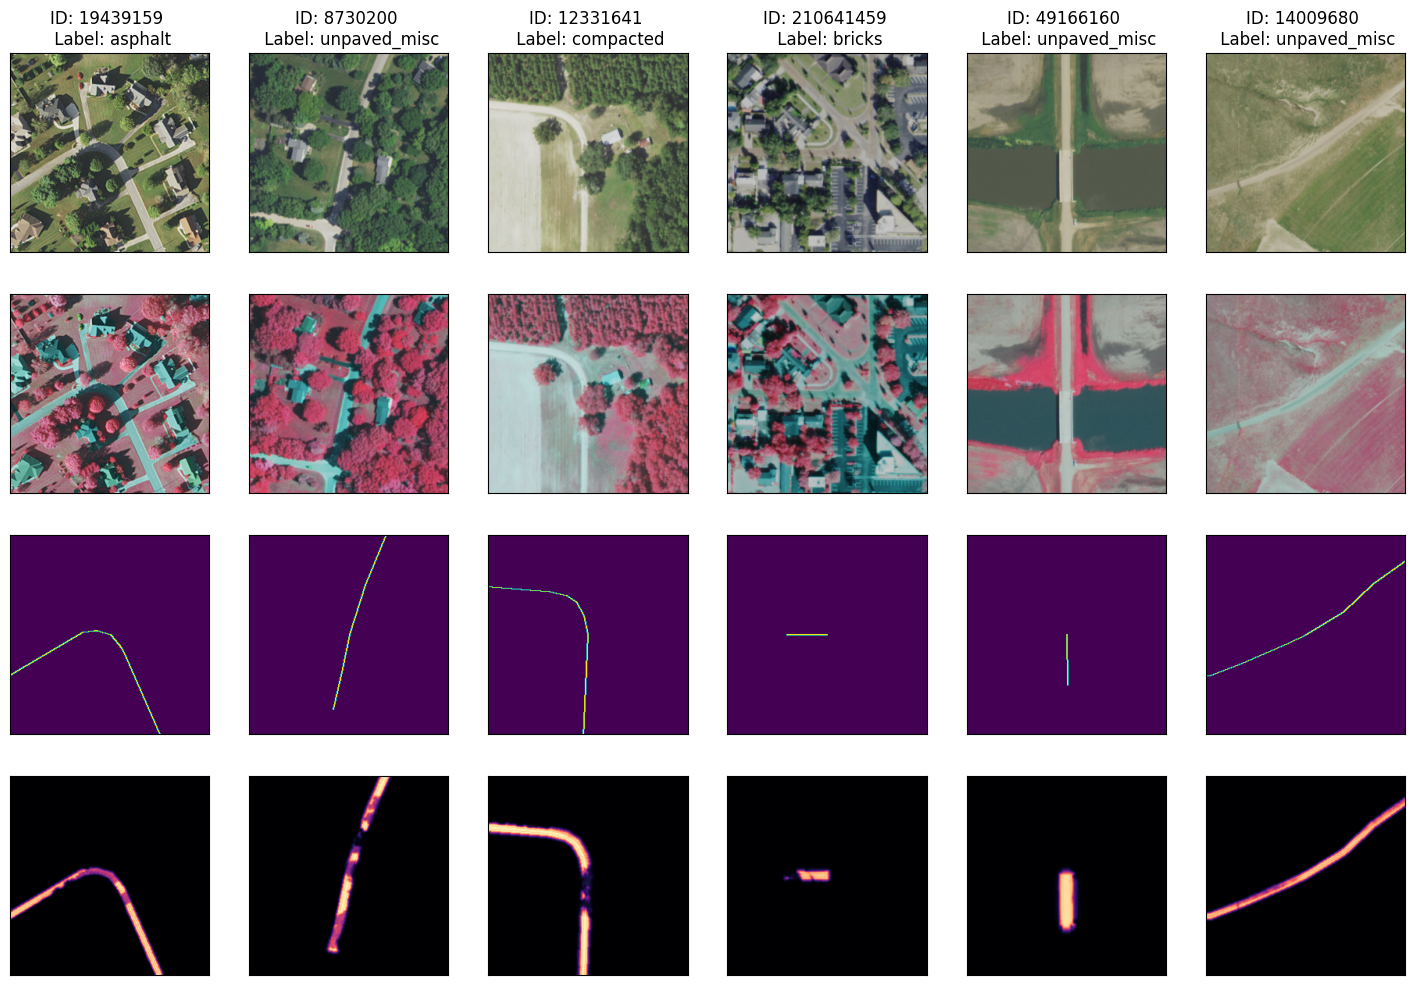

In [2]:
# type: ignore
import matplotlib.pyplot as plt

from osgeo import gdal
from rsc.common.utils import imread

n_cols = 6

df_full = pd.read_csv(pathlib.Path(dataset_path, 'dataset_full.csv'))
df_class = pd.read_csv(pathlib.Path(dataset_path, 'class_weights.csv'))

random_idxs = np.random.choice(len(df_full), size=n_cols, replace=False)

fig, ax = plt.subplots(4, n_cols, figsize=(3*n_cols, 3*4))
for i, idx in enumerate(random_idxs):
    row = df_full.iloc[idx]

    # Render natural color (R-G-B)
    im = imread(row['chip_path'])
    ax[0, i].imshow(im[..., (0, 1, 2)])
    ax[0, i].set_title('ID: %d \n Label: %s' % (row['osm_id'], df_class.iloc[row['class_num']]['class_name']))

    # Render color infrared (NIR-R-G)
    ax[1, i].imshow(im[..., (3, 0, 1)])
    
    # Render mask
    im = imread(row['mask_path'])
    ax[2, i].imshow(im)

    # Render probability mask
    im = imread(row['probmask_path']) / 255.0
    ax[3, i].imshow(im, vmin=0, vmax=1, cmap='magma')

for _ax in ax.flatten():
    _ax.xaxis.set_visible(False)
    _ax.yaxis.set_visible(False)


plt.show()
